# Genre Classification Initial Investigation

### Setup and Installations

### Scratchpad

### Imports

In [1]:
#%%writefile imports.py
%matplotlib inline

# Pytorch Stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchaudio.functional as taf

# Librosa for audio stuff/plotting spectrograms
import numpy as np
import librosa as lr
from librosa.display import *


# Plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Utilities
from IPython.display import Audio
from tqdm.auto import tqdm # progress bars
import random
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import pandas as pd
import ast

### Convenience Functions

In [74]:
#%%writefile utils.py
#from imports import *

# Shorthand amplitude->db conversion
db = lambda x: lr.amplitude_to_db(x)

def plot_spec(sig,sr=22050, channel=None):
    """
    Plots spectrogram of time domain signal (numpy or tensor) with default parameters.
    channel: selects one channel if input has multiple channels
    """
    if type(sig) is torch.Tensor:
        sig = sig.squeeze().numpy()
    if channel != None:
        sig = sig[:,channel].squeeze()
    spec = db(abs(lr.stft(sig))) 
    return specshow(spec, x_axis='time', y_axis='mel', sr=sr)
    
    
def cola_window(win_size, hop_len, win_type=np.hamming):
    """
    Creates a window for which the COLA constraint holds
    """
    w = win_type(win_size)
    w = np.sqrt(w)
    K = np.sqrt(hop_len / sum(pow(w,2)))
    w = w * K
    return w

def fourier(x):
    """
    Converts a time domain tensor to frequency domain and takes angle/phase form
    """
    return taf.magphase(x.rfft(1))

def polar_to_cart(x):
    """
    Converts a tensor with last dimension in [angle, phase] to [a, jb] form
    """
    amp = x[:,0].unsqueeze(-1)
    phase = x[:,1].unsqueeze(-1)
    return torch.cat((amp*torch.cos(phase), amp*torch.sin(phase)), dim=-1)

def db_to_amp(x):
    """
    Converts a pytorch tensor from decibels to amplitude
    """
    return torch.pow(10, (0.5*x))

def amp_to_db(x):
    """
    Converts a pytorch tensor amplitude to decibels
    """
    return taf.amplitude_to_DB(x, 20, -80, 0)

In [118]:
#%%writefile AudioTransforms.py
#from imports import *

class Noise(object):
    """ Adds a random noise file to the original signal at a random normally distributed amplitude
    """
    def __init__(self, noise_path, noise_sr=None, db_mean=-12, db_sd=3, use_cuda=False):
        """
        Args:
            noise_path (str|Path): path to noise files, or list of files
            noise_sr (int): rate at which to resample noise files. If None, uses native sample rate.
            db_mean (float|int): mean amplitude of noise w.r.t. speech signal in decibels (default: -12)
            db_sd (float|int): standard deviation of noise amplitude in decibels (default: 3)
        """
        if type(noise_path) is not list:
            noise_path = list(noise_path.glob('*.wav'))
            
        self.noises, self.srs = zip(*[ta.load(x) for x in tqdm(noise_path, desc='Loading Noises...')])
        
        if use_cuda:
            self.noises = [x.cuda() for x in self.noises]
            
        if noise_sr:
            self.noises = [ta.transforms.Resample(self.srs[i], noise_sr)(self.noises[i]) for i in 
                           tqdm(range(len(self.noises)), desc='Resampling Noises...')]
            
        self.db_dist = (db_mean, db_sd)
        
    def __call__(self, speech):
        db = np.random.normal(self.db_dist[0], self.db_dist[1])
        amp = lr.db_to_amplitude(db)
        n = random.choice(self.noises)
        if speech.shape[-1] < n.shape[-1]:
            return speech + amp * n[:,:speech.shape[-1]]
        else:
            return speech[:,:n.shape[-1]] + amp * n

class Reverb(object):
    """ Adds a convolutional reverb to the speech from a randomly chosen impulse response
        Crops the beginning of the impulse response to non-silent parts to maintain time-alignment of input and target
    """
    def __init__(self, ir_path, ir_sr=None, ir_mono=True, use_cuda=False):
        """
        Args:
            ir_path (str|Path): path to a directory of impulse responses or list of files
            ir_sr (int): rate at which to resample impulse responses. if None (default) uses native sample rate.
            ir_mono (bool): if true, loads only first channel of impulse response, else loads all channels
        """
        if type(ir_path) is not list:
            ir_path = list(ir_path.glob('*.wav'))
            
        self.irs, self.srs = zip(*[ta.load(x) for x in tqdm(ir_path, desc='Loading Impulse Responses...')])
        
        if ir_sr:
            self.irs = [ta.transforms.Resample(self.srs[i], ir_sr)(self.irs[i]) for i in 
                        tqdm(range(len(self.irs)), desc='Resampling Impulse Responses...')]
        if ir_mono:
            self.irs = [x[0,:] for x in self.irs]
            
        if use_cuda:
            self.irs = [x.cuda() for x in self.irs]
            
        # Crop beginning silence of IRS
        crop_idxs = [x.argmax(-1) for x in self.irs]
        self.irs = [x[crop_idxs[i]:].unsqueeze(0).unsqueeze(1) for i,x in enumerate(self.irs)]
    
    def __call__(self, speech):
        ir = random.choice(self.irs)
        if ir.shape[-1] < speech.shape[-1]:
            padding = ir.shape[-1]
            inputs, filters = speech.unsqueeze(0), ir.flip(-1)
        else:
            padding = speech.shape[-1]
            inputs, filters = ir, speech.unsqueeze(0).flip(-1)
            
        return F.conv1d(inputs, filters, padding=padding)[0,:,:speech.shape[-1]].cpu()
        
        # TODO: replace this with torch.conv1d
        #return torch.Tensor(np.convolve(speech.squeeze().numpy(), ir.squeeze().numpy(), 'same')).unsqueeze(0)

class RandomCrop(object):
    """ Crop sample to fixed length starting at random position. Pads with zeros if sample not long enough.
    """
    def __init__(self, length, no_rand=False):
        """
        Args:
            length (int): length of returned clips in samples
            no_rand (bool): if true will always start at beginning of clip. (default: False)
        """
        self.crop_len = length
        self.no_rand = no_rand
        
    def __call__(self, speech):
        if self.no_rand:
            start = 0
        else:
            start = random.randint(0, abs(speech.shape[-1]-self.crop_len))
            
        if speech.shape[-1] > self.crop_len:
            return speech[:,start:start+self.crop_len]
        else:
            retval = torch.zeros((1,self.crop_len))
            retval[:,0:speech.shape[-1]] = speech
            return retval

class LoadCrop(object):
    """ Similar to RandomCrop, but acts on loading the signal to save disk bandwidth.
        About 20x faster in testing when using a frame length of 2048.
    """
    def __init__(self, length, no_rand=False):
        """
        Args:
            length (int): length of returned clips in samples
            no_rand (bool): if true will always start at beginning of clip. (default: False)
        """
        self.crop_len = length
        self.no_rand = no_rand
        
    def __call__(self, fn):
        try:
            si,_ = ta.info(str(fn))

            if si.length > self.crop_len and not self.no_rand:
                start = random.randint(0, si.length-self.crop_len-1)
            else:
                start = 0

            if si.length > (self.crop_len + start):
                return ta.load(fn, num_frames=self.crop_len, offset=start)

            # if problem happened above
            speech,ssr = ta.load(fn)
            if speech.shape[-1] < self.crop_len:
                retval = torch.zeros((1,self.crop_len))
                retval[:,0:speech.shape[-1]] = speech
                return (retval, ssr)
            else: # some other problem occurred reading a chunk of the file
                return (speech[:,:self.crop_len], ssr)
        except:
            return (torch.zeros((1,self.crop_len)), 44100)
        
        
class Normalize(object):
    """ Normalizes a raw-audio waveform to the range specified
    """
    def __init__(self, max_abs_val=1, eps=1e-12):
        self.eps = eps
        self.max_abs_val = max_abs_val
        
    def __call__(self,x):
        return self.max_abs_val * (x / (torch.max(torch.abs(x)) + self.eps))

In [119]:
#%%writefile DeReverbDataset.py
#from imports import *

class FMADataset(Dataset):
    """
    Pytorch dataset for audio sequence to sequence tasks. 
    """
    def __init__(self, root_path, 
                 audio_path='fma_audio/', 
                 meta_path='fma_meta/',
                 genres=None,
                 loadcrop=None,
                 tfms=ta.transforms.MelSpectrogram(sample_rate=44100, n_fft=4096)):
        self.rp = Path(root_path)
        self.audio_files = list((self.rp/audio_path).glob("**/*.mp3"))
        self.labels = pd.read_csv(self.rp/meta_path/"raw_tracks.csv")
        self.labels.track_genres = self.labels.track_genres.apply(self.fix_genres)
        self.gdf = pd.read_csv(self.rp/meta_path/"genres.csv")
        self.tfms = tfms
        
        self.tlgenres = {}
        self.topgs = []
        for i,gid in enumerate(self.gdf.genre_id):
            top = self.gdf['top_level'].iloc[i]
            if top not in self.topgs:
                self.topgs.append(top)
            
            self.tlgenres[gid] = {"name": self.gdf['title'].iloc[i], 
                                  "tlg": self.topgs.index(top)} 
            
        # Filter audio files
        self.audio_files = [x for x in self.audio_files if self.get_genre(x) is not None]
            
        if loadcrop:
            self.loader = loadcrop
        else:
            self.loader = ta.load
            
    def fix_genres(self, genre_string):
        """ Turns strings in genre dataframe into a single-genre dictionary
        """
        try:
            return ast.literal_eval(genre_string)[0]
        except:
            #print(f"couldn't fix genre for {genre_string}")
            return None
        
    def get_genre(self, af, ngs=16):
        """ Utility function to get the genre as a one-hot tensor
        """
        try:
            g = int(self.labels[self.labels.track_id == int(af.parts[-1][:-4])].track_genres.iloc[0]['genre_id'])
            topg = self.tlgenres[g]["tlg"]
            assert topg < ngs, f"genre {topg} > number of possible genres {ngs}"
            return (self.tlgenres[g]["name"], torch.tensor(topg))
        except Exception as E:
            #print(f"no genre found for: {af.parts[-1]}")
            print(E)
            return None
    
    def show(self, idx):
        """ displays a spectrogram with track title and genre
        """
        it = self.__getitem__(idx)
        plt.imshow(torch.log10(it['audio'].squeeze(0).detach().flip(0)))
        gname = it["genre"]
        title = self.labels.track_title[idx]
        artist = self.labels.artist_name[idx]
        plt.title(f"{gname}: {title} by {artist}")
        plt.show()
        display(Audio(self.audio_files[idx]))

    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        afn = self.audio_files[idx]
        try:
            audio, sr = self.loader(afn)
        except Exception as E:
            print(E)
            print(f"problem loading {afn}")
            return {"audio": torch.zeros((1, 1)), "genre": "none", "label": 0}
        
        # Hacky conversion to mono
        audio = audio[0,:].unsqueeze(0)
        
        if self.tfms:
            audio = self.tfms(audio).detach()
            
        # TODO: load label here
        name, label = self.get_genre(afn)
            
        sample =  {"audio": audio, "genre": name, "label": label}
        return sample

In [120]:
datap = Path("/home/zach/Data/fma_medium")

In [121]:
tfms = ta.transforms.MelSpectrogram(sample_rate=44100, n_fft=1024)

In [122]:
dataset = FMADataset(datap, tfms=tfms, loadcrop=LoadCrop(5*44100, no_rand=True))

In [123]:
train_len = int(0.8*len(dataset))
train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_len, len(dataset)-train_len])
train_dl, valid_dl = [DataLoader(ds, batch_size=16, shuffle=True, num_workers=6) for ds in [train_ds, valid_ds]]

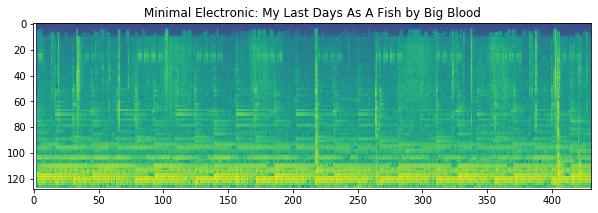

In [124]:
dataset.show(random.choice(range(dataset.__len__())))

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [126]:
rn = models.resnet18(pretrained=True)

Switch number of classes and number of image channels

In [127]:
rn._modules['fc'] = nn.Linear(512, 16)
rn._modules['conv1'] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [128]:
rn.forward(next(iter(train_dl))["audio"])

tensor([[ 1.6978e-01, -4.2887e-01, -2.1282e-01,  1.0640e-02, -8.6547e-02,
         -6.4375e-02,  4.2154e-01, -5.8184e-01, -4.5799e-01,  6.5946e-01,
          8.3857e-02, -2.5860e-01,  4.6708e-02, -6.1128e-01,  1.7766e-01,
         -5.8930e-01],
        [-2.5801e-01, -1.3201e-01,  4.8451e-02, -2.0228e-02,  9.8090e-02,
          1.5222e-02,  1.0546e-01, -3.1590e-01, -2.6696e-01,  2.2369e-02,
         -2.9770e-01, -5.8572e-02,  6.4094e-02, -2.6286e-01, -7.8059e-02,
         -6.9768e-01],
        [ 2.5569e-01,  1.5021e-01, -5.0945e-01, -2.2771e-01, -4.8395e-01,
         -6.0828e-02,  7.6227e-01, -6.5522e-01,  7.2730e-02,  1.4578e-01,
         -2.8237e-02, -3.7428e-01, -7.6022e-01, -3.8594e-01, -6.1625e-01,
         -9.0716e-01],
        [ 2.7288e-01,  4.8921e-02, -3.9941e-01,  1.8810e-01, -8.5964e-01,
          1.3887e-01,  4.7782e-01, -4.9645e-01, -4.5062e-01,  2.1465e-01,
         -4.1137e-01, -5.6194e-02,  1.3425e-01, -3.4578e-01, -6.8314e-02,
         -4.9233e-01],
        [ 5.7959e-01

In [129]:
n_epochs = 10

train_ls = []
valid_ls = []

m = rn
m = m.cuda()
optim = torch.optim.Adam(params=m.parameters(), lr=2e-3)
critereon = nn.CrossEntropyLoss()

for e in tqdm(range(n_epochs), "epoch"):
    m.train()
    for it in tqdm(train_dl, "training example"):
        audio, label = it["audio"], it["label"]
        m.zero_grad()
        out = m(audio.cuda())
        l = critereon(out, label.cuda())
        train_ls.append(l.detach().cpu())
        l.backward()
        optim.step()
    with torch.no_grad():
        for it in tqdm(valid_dl, "validation example"):
            audio, label = it["audio"], it["label"]
            out = m(audio.cuda())
            l = critereon(out, label.cuda())
            valid_ls.append(l.detach().cpu())

    

RuntimeError: Caught RuntimeError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 431 and 140 in dimension 3 at /pytorch/aten/src/TH/generic/THTensor.cpp:689


In [130]:
for batch in tqdm(train_dl):
    try:
        audio, label = batch["audio"], batch["label"]
    except:
        pass

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/zach/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 131 and 431 in dimension 3 at /pytorch/aten/src/TH/generic/THTensor.cpp:689


In [93]:
dataset.get_genre(Path("/home/zach/Data/fma_medium/fma_audio/080/080391.mp3"))

('Ambient', tensor(14))

In [96]:
LoadCrop(5*44100, no_rand=True)("/home/zach/Data/fma_medium/fma_audio/080/080391.mp3").shape

torch.Size([1, 220500])

In [102]:
LoadCrop(5*44100, no_rand=True)("/home/zach/Data/fma_medium/fma_audio/000/000002.mp3")

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.1260e-03,
          -3.1140e-03, -7.7464e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.2293e-02,
           5.8719e-03,  4.3727e-05]]), 44100)

In [100]:
"/home/zach/Data/fma_medium/fma_audio/000/000002.mp3"

'/home/zach/Data/fma_medium/fma_audio/000/000002.mp3'